# Dataset EDA Notebook

In [ ]:
import os
import cv2
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

add_path(str(Path().cwd().parent.absolute() / "src"))
print(f"{sys.path=}")

from config import YamlConfigReader

In [ ]:
%reload_ext autoreload
%autoreload 2

In [15]:
%cd ..
%pwd

/home/ruslan/src/IndustrialMotionDetection


/home/ruslan/src/IndustrialMotionDetection/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/ruslan/src/IndustrialMotionDetection'

In [13]:
conf_file_path = 'conf/meva_preproc.yaml'

In [16]:
config_source = YamlConfigReader(conf_file_path)
params = config_source.get_all()
params

{'annotations_csv': 'data/MEVA/meva_processed/annotations.csv',
 'annotations_folder': 'data/MEVA/meva-data-repo/annotation/DIVA-phase-2/MEVA/kitware-meva-training',
 'bbox_area_limit': 10000,
 'display_annotations': False,
 'padding_frames': 30,
 'result_folder': 'data/MEVA/meva_processed',
 'split_seed': 42,
 'target_activities': ['person_talks_on_phone',
  'person_texts_on_phone',
  'person_picks_up_object',
  'person_reads_document',
  'person_interacts_with_laptop'],
 'test_size': 0.2,
 'videos_root': 'data/MEVA/mevadata-public-01/drops-123-r13'}

In [21]:
annot_df_path = params['annotations_csv']
if not os.path.exists(annot_df_path):
    print('MEVA annotations.csv file not exist')
annot_df_path

'data/MEVA/meva_processed/annotations.csv'

In [43]:
annot_df = pd.read_csv(annot_df_path)
annot_df.head()

video_path  keyframe_id  track_id  \
0  2018-03-15/16/2018-03-15.15-55-00.16-00-00.bus...           30         2   
1  2018-03-15/16/2018-03-15.15-55-00.16-00-00.bus...           31         2   
2  2018-03-15/16/2018-03-15.15-55-00.16-00-00.bus...           32         2   
3  2018-03-15/16/2018-03-15.15-55-00.16-00-00.bus...           33         2   
4  2018-03-15/16/2018-03-15.15-55-00.16-00-00.bus...           34         2   

          action_category  xmin  ymin  xmax  ymax  
0  person_picks_up_object   395   443   493   592  
1  person_picks_up_object   395   442   493   592  
2  person_picks_up_object   395   442   492   592  
3  person_picks_up_object   395   442   492   591  
4  person_picks_up_object   396   442   492   591

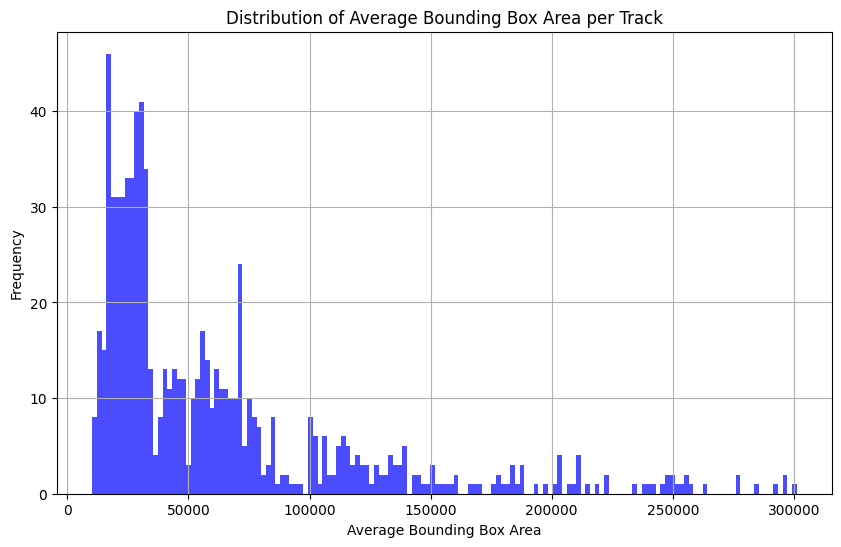

In [23]:
def plot_bbox_area_distribution(annotations_df: pd.DataFrame):
    """
    Plot the distribution of average bounding box area per track.
    """
    annotations_df['bbox_area'] = (annotations_df['xmax'] - annotations_df['xmin']) * (annotations_df['ymax'] - annotations_df['ymin'])

    avg_bbox_area_per_track = annotations_df.groupby(['video_path', 'track_id'])['bbox_area'].mean()

    plt.figure(figsize=(10, 6))
    plt.hist(avg_bbox_area_per_track, bins=150, color='blue', alpha=0.7)
    plt.title('Distribution of Average Bounding Box Area per Track')
    plt.xlabel('Average Bounding Box Area')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
plot_bbox_area_distribution(annot_df)

In [37]:
unique_videos_per_category = (
    annot_df.groupby(['video_path', 'action_category'])
    .size()
    .groupby('action_category')
    .size()
    .reset_index(name='unique_videos')
)
unique_videos_per_category

action_category  unique_videos
0  person_interacts_with_laptop              5
1        person_picks_up_object             48
2         person_reads_document             25
3         person_talks_on_phone             36
4         person_texts_on_phone             93

In [24]:
unique_tracks_per_category = (
    annot_df.groupby(['video_path', 'track_id', 'action_category'])
    .size()
    .groupby('action_category')
    .size()
    .reset_index(name='unique_tracks')
)
unique_tracks_per_category

action_category  unique_tracks
0  person_interacts_with_laptop             17
1        person_picks_up_object            191
2         person_reads_document             53
3         person_talks_on_phone             50
4         person_texts_on_phone            476

In [25]:
unique_frames_per_category = (
    annot_df.groupby(['video_path', 'keyframe_id', 'track_id', 'action_category'])
    .size()
    .groupby('action_category')
    .size()
    .reset_index(name='unique_frames')
)
unique_frames_per_category

action_category  unique_frames
0  person_interacts_with_laptop          56028
1        person_picks_up_object           3938
2         person_reads_document          87257
3         person_talks_on_phone          46658
4         person_texts_on_phone         385774

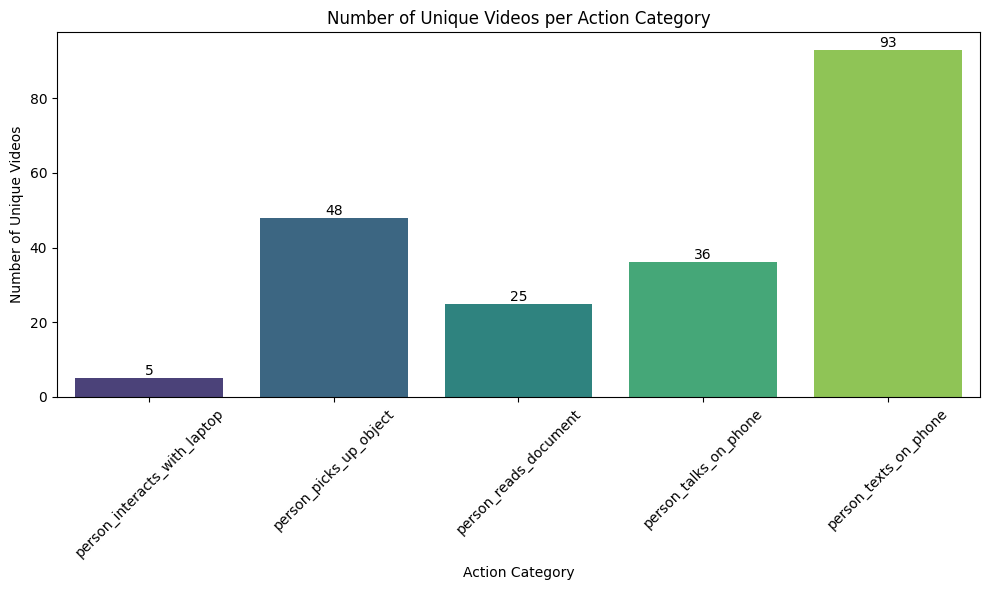

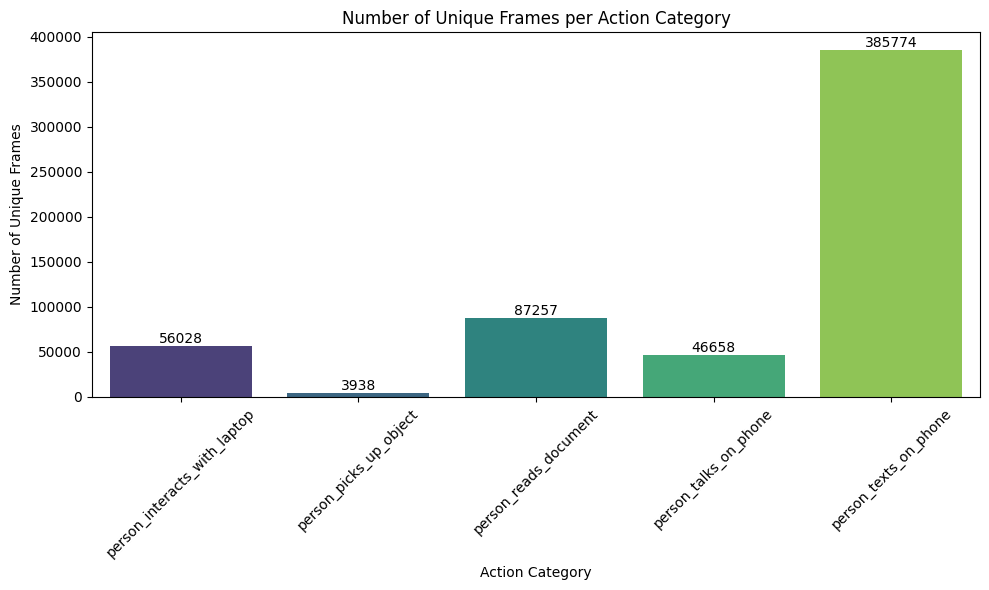

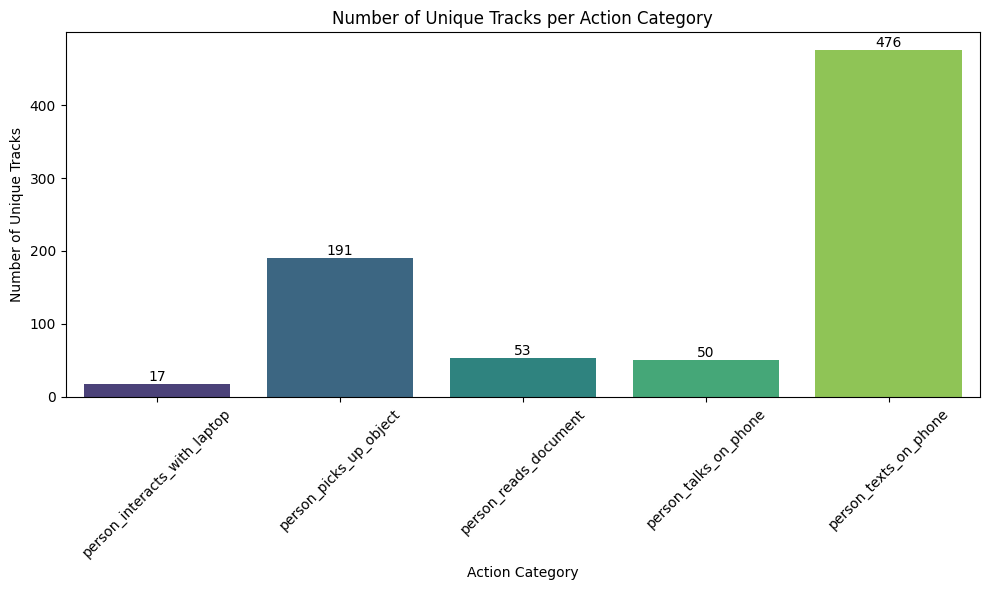

In [38]:
def plot_category_counts(data, y_col, title, y_label, palette='viridis'):
    """
    Plots a bar chart for action category counts with annotations.
    
    Args:
        data (pd.DataFrame): DataFrame containing 'action_category' and count column
        y_col (str): Name of the column to plot on y-axis (e.g., 'unique_frames')
        title (str): Plot title
        y_label (str): Y-axis label
        palette (str): Color palette for the plot
    """
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='action_category', y=y_col, hue='action_category', 
                    data=data, palette=palette, legend=False)
    plt.title(title)
    plt.xlabel('Action Category')
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    
    for index, row in data.iterrows():
        ax.text(index, row[y_col], f"{row[y_col]}", 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
plot_category_counts(
    data=unique_videos_per_category, 
    y_col='unique_videos',
    title='Number of Unique Videos per Action Category',
    y_label='Number of Unique Videos')

plot_category_counts(
    data=unique_frames_per_category, 
    y_col='unique_frames',
    title='Number of Unique Frames per Action Category',
    y_label='Number of Unique Frames')

plot_category_counts(
    data=unique_tracks_per_category, 
    y_col='unique_tracks',
    title='Number of Unique Tracks per Action Category',
    y_label='Number of Unique Tracks')

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-40-01.15-45-01.bus.G506_frange6104-6540.avi, Frame: 191, Bbox Area: 10005.00


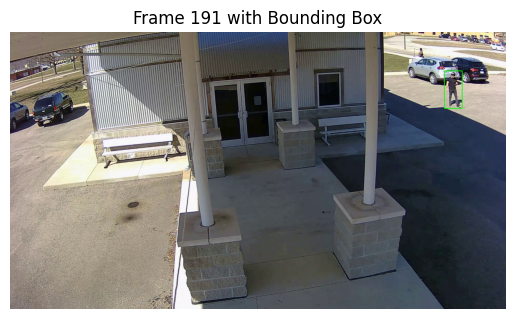

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi, Frame: 6686, Bbox Area: 16480.00


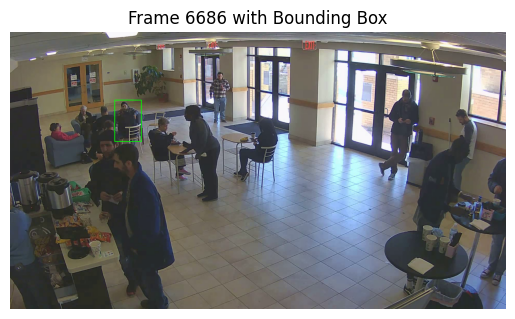

Video Path: /content/meva/2018-03-15/15/2018-03-15.14-55-01.15-00-01.bus.G506_frange0-9001.avi, Frame: 5180, Bbox Area: 17280.00


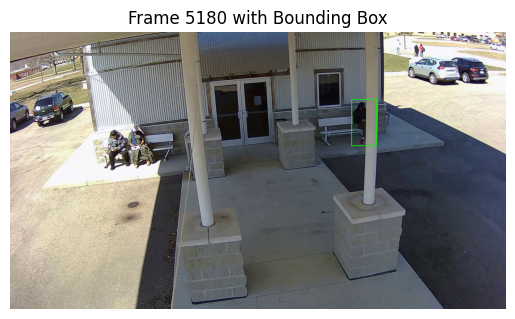

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi, Frame: 3534, Bbox Area: 18232.00


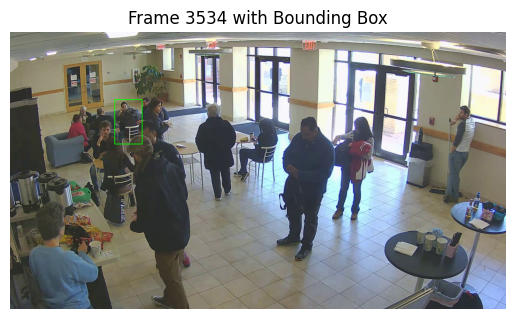

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-10-00.15-15-00.bus.G331_frange0-5802.avi, Frame: 3806, Bbox Area: 19780.00


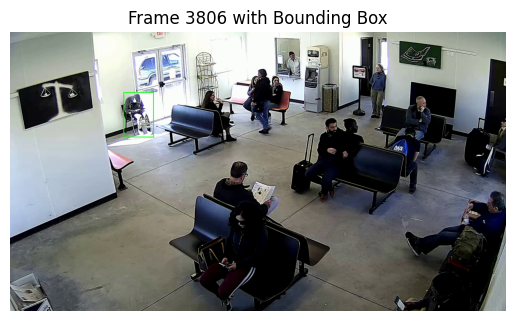

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi, Frame: 167, Bbox Area: 22528.00


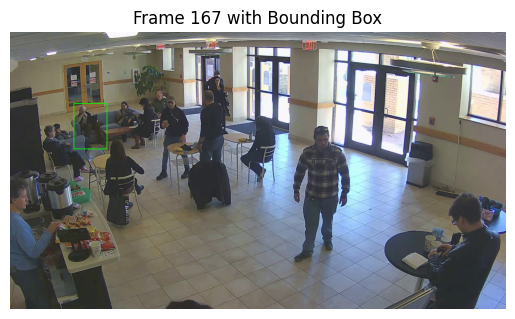

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-15-00.15-20-00.bus.G508_frange4736-9000.avi, Frame: 2618, Bbox Area: 24505.00


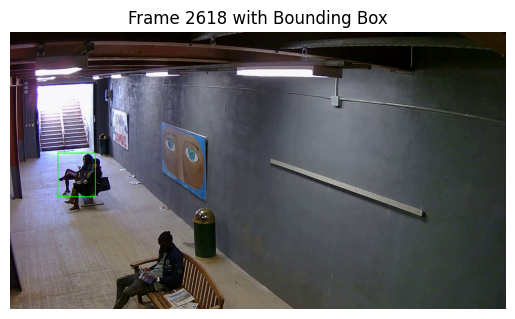

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-00-00.15-05-00.school.G421_frange0-9002.avi, Frame: 5591, Bbox Area: 27150.00


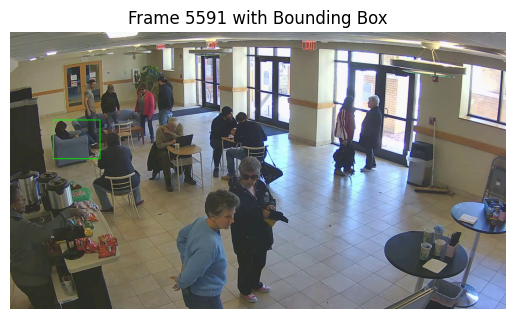

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-05-00.15-10-00.school.G421_frange0-9000.avi, Frame: 1961, Bbox Area: 29106.00


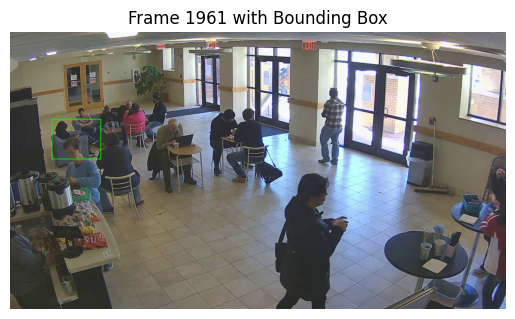

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus.G331_frange4703-9007.avi, Frame: 1223, Bbox Area: 31073.00


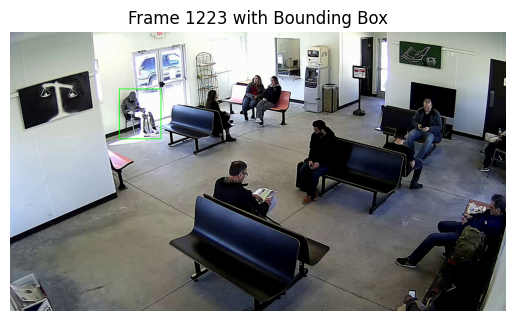

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-35-00.15-40-00.bus.G508_frange399-2927.avi, Frame: 1885, Bbox Area: 34944.00


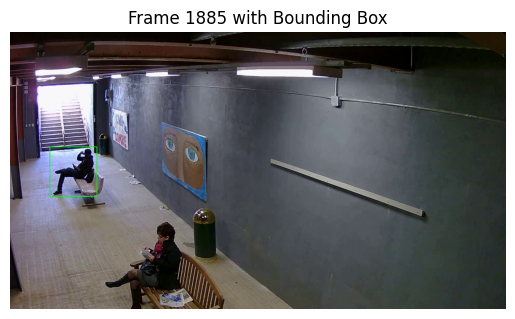

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-45-04.15-50-04.bus.G340_frange7547-8696.avi, Frame: 724, Bbox Area: 46498.00


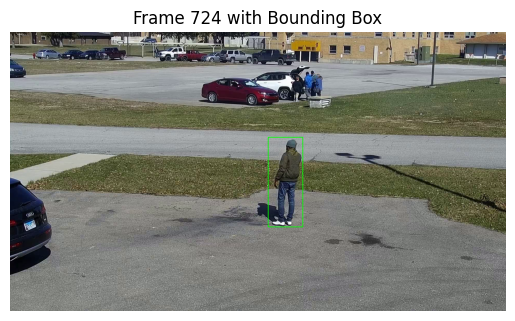

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-00-00.15-05-00.school.G421_frange0-9002.avi, Frame: 2683, Bbox Area: 55620.00


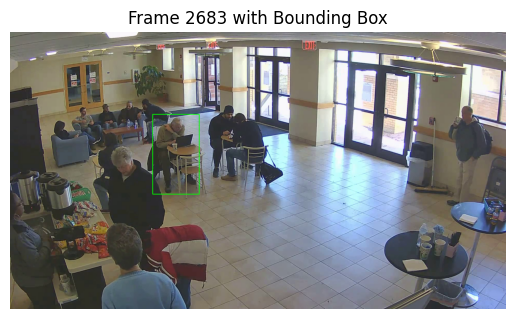

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-05-00.15-10-00.bus.G331_frange0-9008.avi, Frame: 7440, Bbox Area: 60512.00


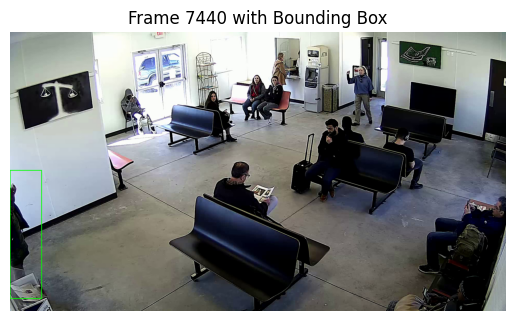

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus.G331_frange0-4404.avi, Frame: 1427, Bbox Area: 66215.00


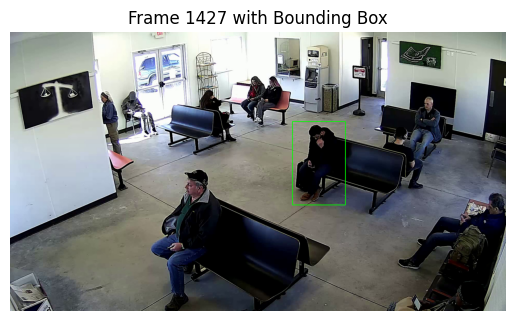

Video Path: /content/meva/2018-03-15/15/2018-03-15.14-55-00.15-00-00.bus.G508_frange0-8997.avi, Frame: 1554, Bbox Area: 71300.00


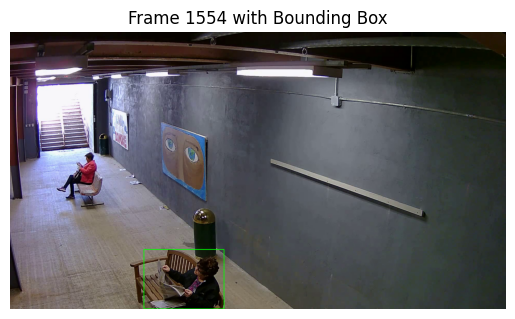

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-05-00.15-10-00.bus.G331_frange0-9008.avi, Frame: 228, Bbox Area: 83916.00


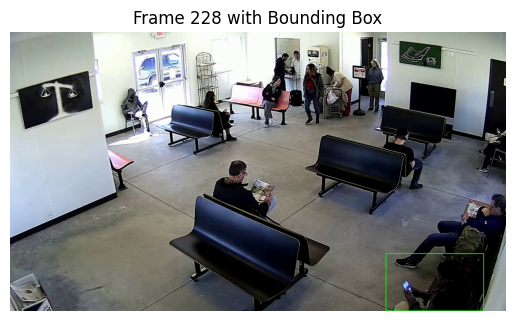

Video Path: /content/meva/2018-03-15/15/2018-03-15.14-55-00.15-00-00.bus.G331_frange0-4706.avi, Frame: 3619, Bbox Area: 101840.00


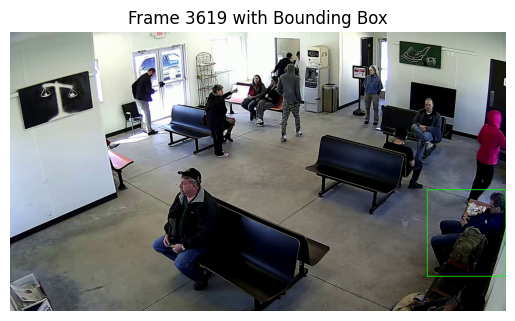

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-05-00.15-10-00.bus.G331_frange0-9008.avi, Frame: 1848, Bbox Area: 113391.00


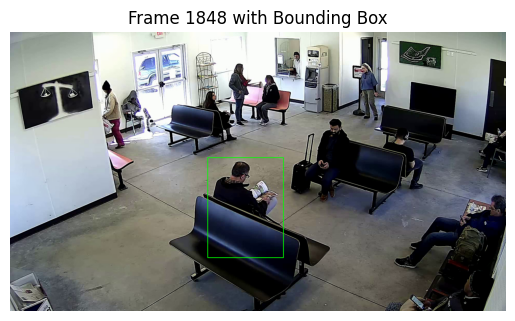

Video Path: /content/meva/2018-03-15/15/2018-03-15.15-10-00.15-15-00.bus.G331_frange0-5802.avi, Frame: 3214, Bbox Area: 135441.00


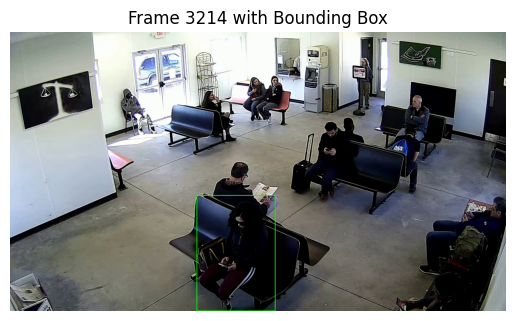

In [32]:
def transform_path(video_path):
    p = '/'.join(video_path.split('/')[3:])
    return f"{os.getcwd()}/data/MEVA/meva_processed/{p}"

def plot_frame_with_bbox(video_path: str, frame_num: int, bbox_coords: tuple):
    """
    Plot a specific frame from the video with the bounding box.
    """
    cap = cv2.VideoCapture(transform_path(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_num >= total_frames:
        print(f"Frame {frame_num=} is out of range {total_frames=} in {video_path=}")
        cap.release()
        return
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    if not ret:
        print(f"Frame {frame_num} not found in {video_path}")
        return
    xmin, ymin, xmax, ymax = bbox_coords
    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {frame_num} with Bounding Box")
    plt.axis('off')
    plt.show()
    cap.release()

def show_video_frame_with_avg_bbox(annotations_df: pd.DataFrame, n=20):
    """
    Print video paths with average bounding box area for all tracks.
    Also, plot one frame with the bounding box for each video.
    """
    annotations_df['bbox_area'] = (annotations_df['xmax'] - annotations_df['xmin']) * \
                                  (annotations_df['ymax'] - annotations_df['ymin'])

    sorted_df = annotations_df.sort_values('bbox_area')

    step = max(1, len(sorted_df) // n)
    selected_indices = range(0, len(sorted_df), step)[:n]

    for idx in selected_indices:
        if idx >= len(sorted_df):
            continue
            
        row = sorted_df.iloc[idx]
        print(f"Video Path: {row['video_path']}, Frame: {row['keyframe_id']}, Bbox Area: {row['bbox_area']:.2f}")
        plot_frame_with_bbox(
            video_path=row['video_path'], 
            frame_num=row['keyframe_id'], 
            bbox_coords=(row['xmin'], row['ymin'], row['xmax'], row['ymax']))
        
show_video_frame_with_avg_bbox(annot_df)

In [33]:
def count_tracks_with_avg_bbox_area_less_than(annotations_df: pd.DataFrame, threshold=10000):
    """
    Count the number of videos where the average bounding box area per track is less than the threshold.
    """
    annotations_df['bbox_area'] = (annotations_df['xmax'] - annotations_df['xmin']) * \
                                  (annotations_df['ymax'] - annotations_df['ymin'])

    avg_track_box_area = annotations_df.groupby(['video_path', 'track_id'])['bbox_area'].mean().reset_index()

    videos_with_small_bbox = avg_track_box_area[avg_track_box_area['bbox_area'] < threshold]

    print(f"Number of videos with average bbox area per track < {threshold}: {len(videos_with_small_bbox)}/{len(avg_track_box_area)}")
    
count_tracks_with_avg_bbox_area_less_than(annot_df)

Number of videos with average bbox area per track < 10000: 0/787


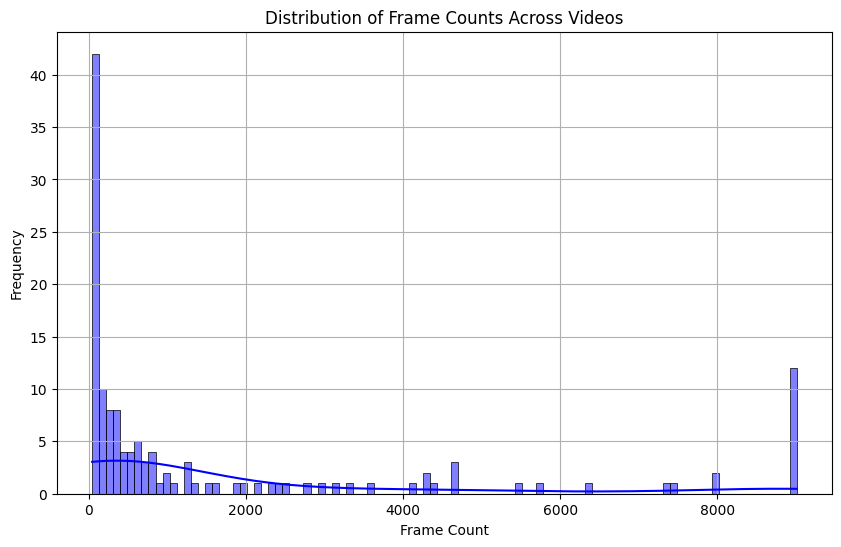

In [34]:
def plot_frame_count_distribution(annotations_df: pd.DataFrame):
    """
    Plot the distribution of frame counts across videos.
    """
    frame_counts = annotations_df.groupby('video_path')['keyframe_id'].max().reset_index()
    frame_counts.rename(columns={'keyframe_id': 'frame_count'}, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.histplot(frame_counts['frame_count'], bins=100, kde=True, color='blue')
    plt.title('Distribution of Frame Counts Across Videos')
    plt.xlabel('Frame Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_frame_count_distribution(annot_df)

In [ ]:
def plot_frame_count_distribution(annotations_df: pd.DataFrame):
    """
    Plot the distribution of frame counts across videos.
    """
    frame_counts = annotations_df.groupby('video_path')['keyframe_id'].max().reset_index()
    frame_counts.rename(columns={'keyframe_id': 'frame_count'}, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.histplot(frame_counts['frame_count'], bins=100, kde=True, color='blue')
    plt.title('Distribution of Frame Counts Across Videos')
    plt.xlabel('Frame Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_frame_count_distribution(annot_df)

In [58]:
frame_count = annot_df.groupby(['video_path', 'track_id', 'action_category'])['keyframe_id'].count().reset_index()
frame_count.rename(columns={'keyframe_id': 'frame_count'}, inplace=True)
frame_count

video_path  track_id  \
0    2018-03-15/14/2018-03-15.14-50-00.14-55-00.bus...        14   
1    2018-03-15/14/2018-03-15.14-50-00.14-55-00.bus...        19   
2    2018-03-15/14/2018-03-15.14-50-00.14-55-00.bus...        20   
3    2018-03-15/14/2018-03-15.14-50-00.14-55-00.bus...        21   
4    2018-03-15/14/2018-03-15.14-50-00.14-55-00.bus...        22   
..                                                 ...       ...   
782  2018-03-15/15/2018-03-15.15-50-03.15-55-03.sch...        10   
783  2018-03-15/15/2018-03-15.15-50-03.15-55-03.sch...         7   
784  2018-03-15/15/2018-03-15.15-50-03.15-55-03.sch...         8   
785  2018-03-15/15/2018-03-15.15-50-04.15-55-04.bus...         1   
786  2018-03-15/16/2018-03-15.15-55-00.16-00-00.bus...         2   

            action_category  frame_count  
0    person_picks_up_object           27  
1     person_texts_on_phone         1420  
2     person_texts_on_phone          973  
3     person_texts_on_phone          630  
4     person_texts_on_phone          110  
..                      ...          ...  
782   person_texts_on_phone          245  
783   person_texts_on_phone           89  
784   person_talks_on_phone           83  
785   person_talks_on_phone         2164  
786  person_picks_up_object           22  

[787 rows x 4 columns]

In [ ]:
frame_count['action_category'].value_counts()

action_category
person_texts_on_phone           476
person_picks_up_object          191
person_reads_document            53
person_talks_on_phone            50
person_interacts_with_laptop     17
Name: count, dtype: int64

In [ ]:
frame_count.groupby('action_category')['frame_count'].mean()

action_category
person_interacts_with_laptop    3295.764706
person_picks_up_object            20.617801
person_reads_document           1646.358491
person_talks_on_phone            933.160000
person_texts_on_phone            810.449580
Name: frame_count, dtype: float64

In [75]:
frame_count.groupby('action_category')['frame_count'].median()

action_category
person_interacts_with_laptop    3390.0
person_picks_up_object            19.0
person_reads_document           1080.0
person_talks_on_phone            390.5
person_texts_on_phone            412.0
Name: frame_count, dtype: float64

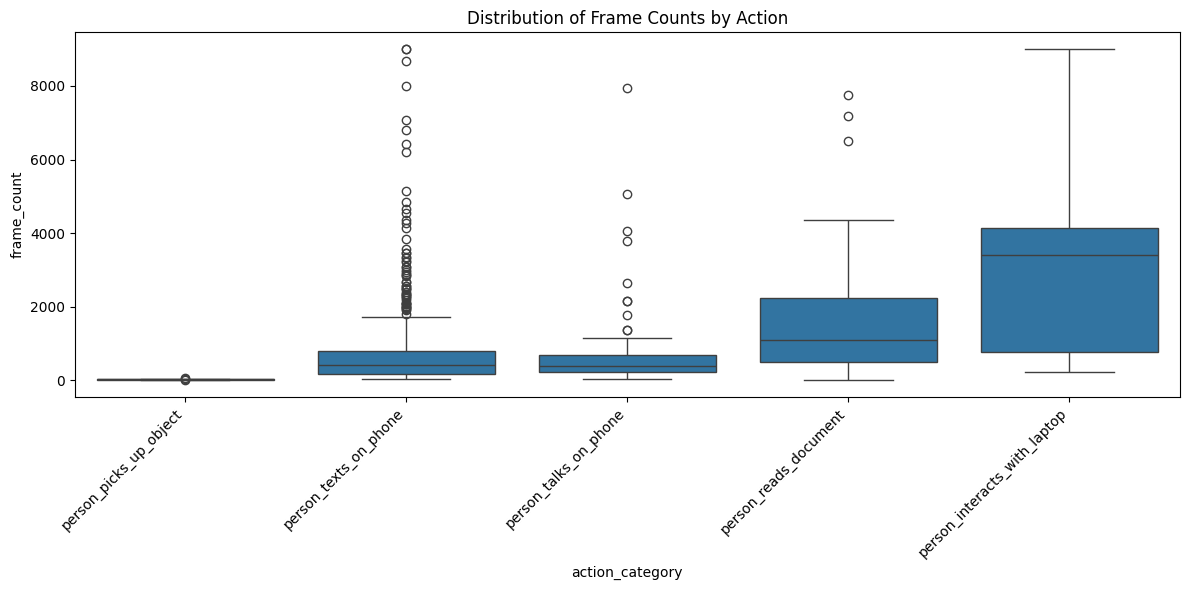

In [91]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=frame_count, x='action_category', y='frame_count')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Frame Counts by Action')
plt.tight_layout()
plt.show()

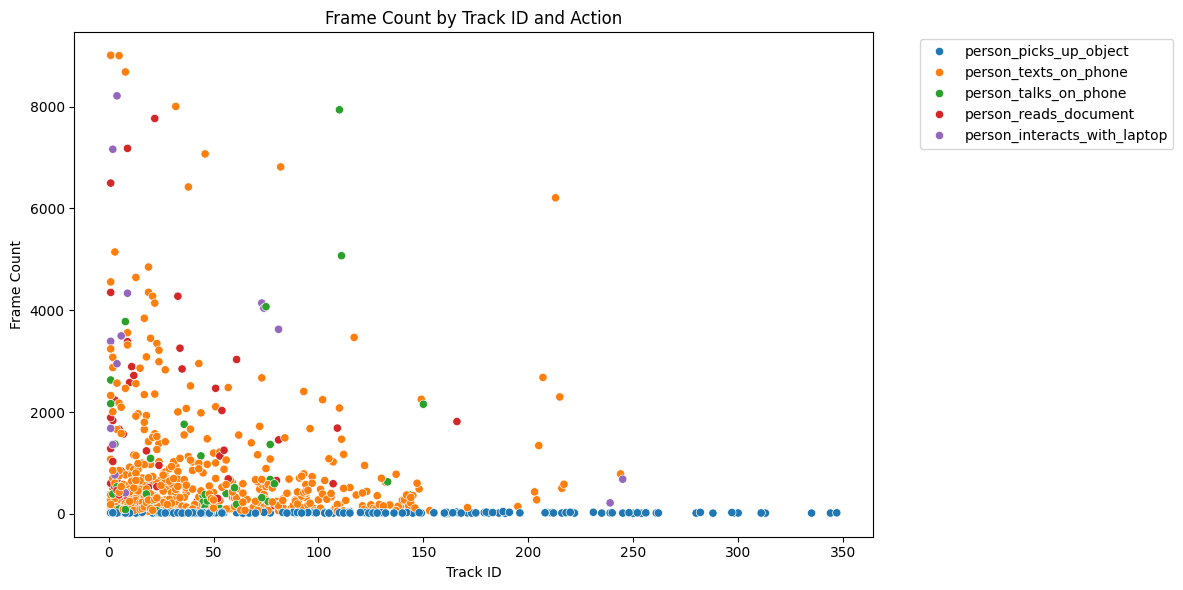

In [62]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=frame_count, x='track_id', y='frame_count', hue='action_category')
plt.title('Frame Count by Track ID and Action')
plt.xlabel('Track ID')
plt.ylabel('Frame Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [94]:
def find_multi_track_frames(annotations_df: pd.DataFrame):
    multi_track_frames = (annotations_df.groupby(['video_path', 'keyframe_id'])['track_id']
                         .nunique()
                         .reset_index(name='track_count'))

    result = multi_track_frames[multi_track_frames['track_count'] > 1]
    
    return result.sort_values(['track_count'], ascending=True)

find_multi_track_frames(annot_df)

video_path  keyframe_id  \
196216  2018-03-15/15/2018-03-15.15-40-00.15-45-00.sch...         4782   
196344  2018-03-15/15/2018-03-15.15-40-00.15-45-00.sch...         4910   
196343  2018-03-15/15/2018-03-15.15-40-00.15-45-00.sch...         4909   
196342  2018-03-15/15/2018-03-15.15-40-00.15-45-00.sch...         4908   
196341  2018-03-15/15/2018-03-15.15-40-00.15-45-00.sch...         4907   
...                                                   ...          ...   
48551   2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus...         1951   
48550   2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus...         1950   
48549   2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus...         1949   
48548   2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus...         1948   
48547   2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus...         1947   

        track_count  
196216            2  
196344            2  
196343            2  
196342            2  
196341            2  
...             ...  
48551             9  
48550             9  
48549             9  
48548             9  
48547             9  

[159957 rows x 3 columns]

In [95]:
import gc
gc.collect()

1604